# E5 Spectrogram classification 모델 구현

*****

일시: 2020년 1월 21일

- **학습 목표**: 사람이 말하는 단어를 인공지능 모델로 구분하고, 2차원 스펙토그램 데이터를 입력받아 기본 버전과 스킵 커넥션으로 나누어 학습시켜보자.

- 1차원 waveform 데이터가 2차원 스펙토그램으로 데이터 변환되면, waveform 데이터일 때보다 학습한 모델의 성능이 더 나을까?

*****

# Step 1. 데이터 처리와 분류

1. waveform 데이터를 불러와 확인해줍니다.

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data_2 = np.load(data_path)

In [2]:
print("Wave data shape : ", speech_data_2["wav_vals"].shape) # 1초 길이의 오디오 음성데이터 50620개/ 샘플레이트를 8000으로 재조정
print("Label data shape : ", speech_data_2["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [3]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data_2["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data_2 = speech_data_2["wav_vals"][rand]
print("Wave data shape : ", data_2.shape)
print("label : ", speech_data_2["label_vals"][rand])

ipd.Audio(data_2, rate=sr)

rand num :  5791
Wave data shape :  (8000,)
label :  ['left']


2. 라벨 데이터를 처리합니다. 라벨 데이터는 단어 정답으로 텍스트 형태입니다.

In [4]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


3. 텍스트 형의 라벨 데이터를 학습에 사용하기 위해 인덱스 형태로 바꿔줍니다. 

In [5]:
temp = []
for v in speech_data_2["label_vals"]:
    temp.append(label_value[v[0]])
label_data_2 = np.array(temp)

label_data_2

array([ 3,  3,  3, ..., 11, 11, 11])

4. 학습을 위해 데이터를 먼저 분리해줍니다. ```sklearn```의 ```train_test_split```함수를 이용하여 train, test 데이터셋을 분리해줍니다. 메모리를 위해 쓰지 않는 데이터는 간간히 지워줍니다.

In [6]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav_2, test_wav_2, train_label_2, test_label_2 = train_test_split(speech_data_2["wav_vals"], 
                                                                label_data_2, 
                                                                test_size=0.1,  
                                                                shuffle=True)
print(train_wav_2.shape)
print(test_wav_2.shape)
print(train_label_2.shape)
print(test_label_2.shape)

del speech_data_2

(45558, 8000)
(5062, 8000)
(45558,)
(5062,)


5. 1차원 wavwform 데이터를 2차원 spectogram 데이터로 변환해줍니다. train과 test 데이터셋을 각각 변환해줍니다.

#### train 데이터셋

In [7]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형.
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

train_spec_2=[] # 빈 리스트에 1차원 데이터 하나씩.
for wav in train_wav_2: 
    stft = wav2spec(wav)
    train_spec_2.append(stft)
train_spec_2 = np.array(train_spec_2)
train_spec_2.shape

# 위에서 뽑았던 sample data
print("Waveform shape : ", train_wav_2.shape)
print("Spectrogram shape : ",train_spec_2.shape)

del train_wav_2

Waveform shape :  (45558, 8000)
Spectrogram shape :  (45558, 130, 126)


- 처음에 이 spectogram 이미지로 변환시켰을 때, 50620장을 한번에 보는 코드를 짜서 계속 커널이 터졌습니다. 백혜림 퍼실님의 도움으로 1씩 보여주는 코드를 넣어 커널이 터짐을 해결할 수 있었습니다.   

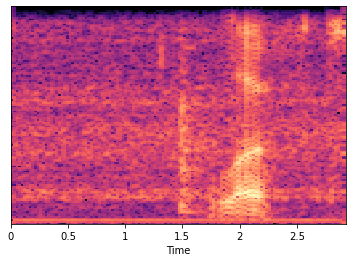

In [8]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(train_spec_2[0], ref=np.max), x_axis='time')

#### test 데이터셋

In [9]:
test_spec_2=[] 
for wav in test_wav_2: 
    stft = wav2spec(wav)
    test_spec_2.append(stft)
test_spec_2 = np.array(test_spec_2)
test_spec_2.shape

print("Waveform shape : ", test_wav_2.shape)
print("Spectrogram shape : ",test_spec_2.shape)

del test_wav_2

Waveform shape :  (5062, 8000)
Spectrogram shape :  (5062, 130, 126)


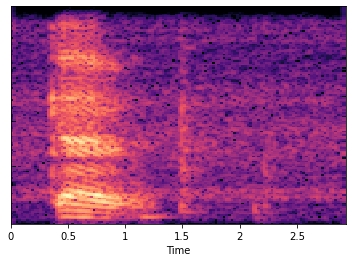

In [10]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(test_spec_2[0], ref=np.max), x_axis='time')

# Step 2. 학습을 위한 하이퍼파라미터 설정

6. 모델 체크포인트 저장을 위한 체크포인트 경로를 설정합니다.

In [11]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj20/aiffel/speech_recognition/models/wav'

# Step 3. 데이터셋 구성

7. 아래 사항을 넣어서 데이터셋을 구성합니다.

- ```tf.data.Dataset```을 이용합니다.
- ```from_tensor_slices```함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용합니다.
- map과 batch를 이용한 데이터 전처리합니다.

In [12]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [13]:
import tensorflow as tf

# for train
train_dataset_2 = tf.data.Dataset.from_tensor_slices((train_spec_2, train_label_2))
train_dataset_2 = train_dataset_2.map(one_hot_label)
train_dataset_2 = train_dataset_2.repeat().batch(batch_size=batch_size)
print(train_dataset_2)

# for test
test_dataset_2 = tf.data.Dataset.from_tensor_slices((test_spec_2, test_label_2))
test_dataset_2 = test_dataset_2.map(one_hot_label)
test_dataset_2 = test_dataset_2.batch(batch_size=batch_size)
print(test_dataset_2)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


# Step 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

8. 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용합니다.

## 1. Conv1D layer 적용

In [24]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_2 = tf.keras.Model(input_tensor, output_tensor)

model_spec_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 130, 32)           36320     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 65, 32)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 65, 64)            18496     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 32, 64)            0   

9. 현재 라벨이 될 수 있는 단어는 12개입니다. 이 12개의 클래스를 구분하기 위해서는 멀티 클래스 분류가 필요하기에 손실함수로 교차 엔트로피 오차를 사용합니다.

In [25]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

10. ```fit```을 할 때, ```callback```함수를 사용해서 학습 중간에 원하는 동작을 하도록 설정합니다.

In [26]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

11. 모델을 훈련시킵니다.

In [27]:
# 배치 사이즈 32, 최대 에포크 10
#30분 내외 소요 (메모리 사용량에 주의)
history_spec_2 = model_spec_2.fit(train_dataset_2, epochs=max_epochs, # max_epochs
                    steps_per_epoch=len(train_spec_2) // batch_size,
                    validation_data=test_dataset_2,
                    validation_steps=len(test_spec_2) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.4271 - accuracy: 0.5069
Epoch 00001: val_loss improved from inf to 0.90533, saving model to /home/aiffel-dj20/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 11s 8ms/step - loss: 1.4271 - accuracy: 0.5069 - val_loss: 0.9053 - val_accuracy: 0.6764
Epoch 2/10
1417/1423 [============================>.] - ETA: 0s - loss: 0.7022 - accuracy: 0.7635
Epoch 00002: val_loss improved from 0.90533 to 0.51500, saving model to /home/aiffel-dj20/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 11s 7ms/step - loss: 0.7014 - accuracy: 0.7637 - val_loss: 0.5150 - val_accuracy: 0.8212
Epoch 3/10
1421/1423 [============================>.] - ETA: 0s - loss: 0.4621 - accuracy: 0.8451
Epoch 00003: val_loss improved from 0.51500 to 0.41358, saving model to /home/aiffel-dj20/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 11s 8ms/step - l

# Step 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

12. 학습결과를 loss, accuracy를 그래프로 표현해봅니다. training loss와 validation loss의 차이가 커지는 경우, 오버피팅이 일어나는 것이기에 수정이 필요합니다.  

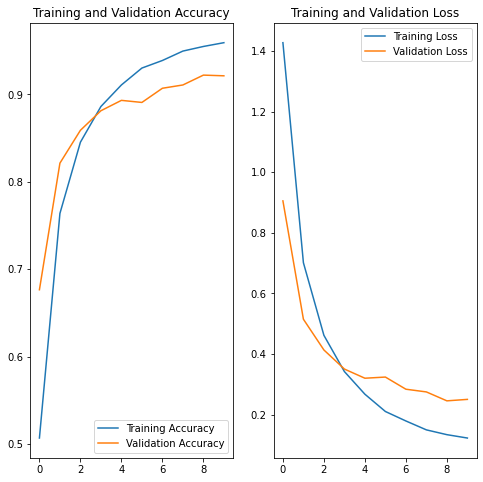

In [28]:
import matplotlib.pyplot as plt

acc = history_spec_2.history['accuracy']
val_acc = history_spec_2.history['val_accuracy']

loss=history_spec_2.history['loss']
val_loss=history_spec_2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Step 6. Test dataset을 이용해서 모델의 성능을 평가

13. 예측값과 실제 값이 얼마나 일치하는지 확인하기 위해서 저장한 weight를 불러옵니다.

In [29]:
# # Evaluation 
model_spec_2.load_weights(checkpoint_dir)
results_2 = model_spec_2.evaluate(test_dataset_2)

159/159 [==============================] - 0s 3ms/step - loss: 0.2455 - accuracy: 0.9220


14. loss와 accuravy를 확인해봅니다.

In [30]:
# loss
print("loss value: {:.3f}".format(results_2[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results_2[1]*100))

loss value: 0.246
accuracy value: 92.1968%


15. test 데이터셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인해봅니다.

In [38]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec_2), size=1, replace=False)

batch_xs = test_spec_2[batch_index]
batch_ys = test_label_2[batch_index]
y_pred_ = model_spec_2(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130,126), rate=8000)

label :  no


16. 확인해 본 test 데이터셋의 라벨과 우리 모델의 실제 예측 결과를 비교해봅니다.

In [39]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: no(Correct!)


## 2. Skip-Connection

17. 다른 모델로 Skip-Connection을 구현합니다. Skip-Connection은 데이터가 레이어를 뛰어넘어 레이어를 통과한 값에 더해주는 형식으로 구현됩니다.

In [40]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip_2 = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 130, 32)      36320       input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 130, 32)      9248        conv1d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_12 (MaxPooling1D) (None, 65, 32)       0           conv1d_31[0][0]                  
____________________________________________________________________________________________

18. 역시 이 모델도 손실함수와 optimizer를 설정하고, ```callback```함수를 적용합니다. 

In [41]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

19. 모델을 훈련시킵니다.

In [42]:
#30분 내외 소요
history_spec_skip_2 = model_spec_skip_2.fit(train_dataset_2, epochs=max_epochs, # max_epochs
                    steps_per_epoch=len(train_spec_2) // batch_size,
                    validation_data=test_dataset_2,
                    validation_steps=len(test_spec_2) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1422/1423 [============================>.] - ETA: 0s - loss: 1.5139 - accuracy: 0.4886
Epoch 00001: val_loss improved from inf to 0.95934, saving model to /home/aiffel-dj20/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 12s 8ms/step - loss: 1.5136 - accuracy: 0.4888 - val_loss: 0.9593 - val_accuracy: 0.6681
Epoch 2/10
1420/1423 [============================>.] - ETA: 0s - loss: 0.7282 - accuracy: 0.7582
Epoch 00002: val_loss improved from 0.95934 to 0.57664, saving model to /home/aiffel-dj20/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 11s 8ms/step - loss: 0.7276 - accuracy: 0.7585 - val_loss: 0.5766 - val_accuracy: 0.8002
Epoch 3/10
1417/1423 [============================>.] - ETA: 0s - loss: 0.4839 - accuracy: 0.8395
Epoch 00003: val_loss improved from 0.57664 to 0.42906, saving model to /home/aiffel-dj20/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 1

20. 학습결과를 loss, accuracy를 그래프로 표현해봅니다.

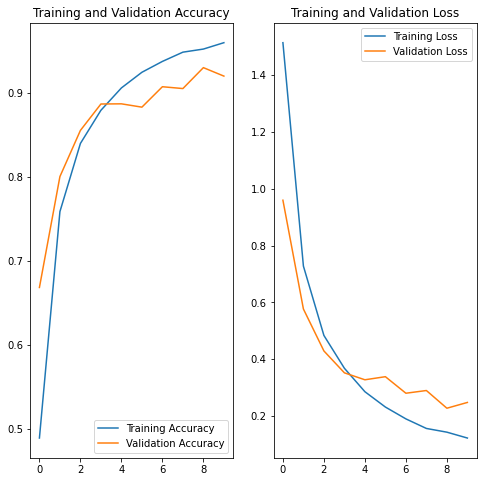

In [43]:
import matplotlib.pyplot as plt

acc = history_spec_skip_2.history['accuracy']
val_acc = history_spec_skip_2.history['val_accuracy']

loss=history_spec_skip_2.history['loss']
val_loss=history_spec_skip_2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

21. loss와 accuracy를 확인하고, test 데이터셋을 골라 직접 들어본 후, 모델의 예측이 맞는지 확인해봅니다.

In [46]:
# Evaluation 
model_spec_skip_2.load_weights(checkpoint_dir)
results_skip_2 = model_spec_skip_2.evaluate(test_dataset_2)

# loss
print("loss value: {:.3f}".format(results_skip_2[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results_skip_2[1]*100))

159/159 [==============================] - 0s 3ms/step - loss: 0.2273 - accuracy: 0.9301
loss value: 0.227
accuracy value: 93.0067%


In [47]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec_2), size=1, replace=False)

batch_xs = test_spec_2[batch_index]
batch_ys = test_label_2[batch_index]
y_pred_ = model_spec_skip_2(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130,126), rate=8000)

label :  unknown


22. 정답 라벨과 모델의 예측값이 맞는지 확인합니다.

In [ ]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')   

# 루브릭 평가

1. 음성데이터를 2차원 Spectrogram으로 변환하여 데이터셋을 구성하였나? 그리고 스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었나?

> 2차원 Spectrogram 데이터로 변환하여 train/test 데이터셋을 구성했습니다. 그리고 스펙트로그램 시각화도 완료했습니다.      
> 하지만 차원 수만 바뀐다고 1차원 음성 데이터가 2차원 Spectrogram 데이터가 어떻게 되는지는 아직 이해하지 못했습니다. 이번 프로젝트에서는 reshape 메소드(?)가 아주 큰 일을 하는 것 같은데, reshape를 언제 쓰는지, 어떻게 동작하는지 잘 몰라서 애를 많이 먹었습니다. 그리고 차원을 어떻게 새는건지도 헷갈립니다. 이 부분은 공부를 더 해야할 것 같습니다. 

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동하나? 스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능한가?

> 두 모델은 모두 정상작동했으며, evaluation/test 단계를 무리 없이 진행했습니다. 
> "스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴"이라는 말은 뜻을 이해 못했습니다. 1차원 데이터를 돌렸던 모델이 2차원 데이터도 잘 돌렸다는 말이라면, 답은 '네'입니다.

> 그런데 의구심이 드는 게 있습니다. 분명 1차원 waveform데이터를 사용했을 때는 1 epoch를 돌리는데 1분은 족히 넘었던 것 같은데, 2차원 spectogram 데이터로 돌리니 1 epoch 당 11초 정도 밖에 걸리지 않았습니다.     
> 왜 그럴까? 제가 데이터셋을 잘못 만든 것인지, 아니면 원래 1차원 음성데이터를 2차원 spectogram 데이터로 바꾸면 일어나는 현상인지 모르겠습니다. 후자라면 의문점은 저차원에서 고차원으로 갔는데 왜 속도가 빨라지냐는 것입니다. 제 생각으로는 저차원을 고차원으로 늘렸지만, 데이터의 양은 같으니 처리할 양이 줄어들어서인 것 같습니다. 음... 이번 노드는 거의 이해 못한 것이 태반입니다. 음성 쪽은 솔직히 노드를 읽어도 모르겠습니다. 음성...이쪽은 제가 갈 길이 아닌 것 같습니다.

> 다만 아쉬운 점은 1차원 음성데이터였을 때는 ```ipd.Audio()```를 통해 음성을 들어볼 수 있었는데, 데이터를 변환해서인지 해당 메서드를 사용해도 음성을 들어볼 수 없었습니다. 이걸 사용하려면 모델이 예측한 결과에 해당하는 음성데이터의 번호를 따로 따서 들어보는 수 밖에 없을 것 같습니다.    

3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였나? evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재하나?

> 두 모델 모두 평가 결과에서 각각 92%와 93%의 정확도를 보였습니다. 
> 모델은 좋은 결과를 냈지만 저는 모델에 대한 이해가 부족함을 확실히 느꼈습니다. 1차원 waveform 데이터를 사용했을 때와 2차원 스펙토그램 데이터를 사용할 때 모델의 어떤 부분을 바꿔줘야하는지 저 혼자는 찾기 힘들었습니다. 조원들의 도움이 없었다면 데이터를 다 스펙토그램으로 바꿔놓고 모델은 waveform 데이터로 돌리고 제출했을 겁니다.

# 회고 및 성찰, 생각

회고를 쓰는 이 시점까지 저는 이 노드의 대부분을 이해하지 못했습니다. 이 노드를 왜 해야하는지 이해조차 하지 못하니 하기 싫어지고, 미루게 되었습니다. 게다가 모델을 돌리는데 30분 씩 걸리니 더더욱 하기 싫었었죠.  

그래서 제출시간 직전까지 노트북을 쓰고 있습니다. 지금 오후 10시인데 아까 오후 7시 쯤 샤워하면서 인공지능이 사람의 단어를 구분하는 것을 어떻게 활용할 수 있을지 생각해봤습니다. 

**"유튜브 자동생성 자막처럼 사람의 음성을 자막으로 나타낼 수 있다."**

저거라면 이번 노드에서 배운 것을 활용하면 만들 수 있겠다는 생각을 했습니다. (물론 못 만들지만 아이디어가 그렇다는 것이죠.) 이걸 제출일자인 오늘이 아니라 좀 더 일찍 깨달았다면 즐기면서 프로젝트를 진행할 수 있지 않았을까 합니다. 목적이 없으면 움직이지 못하는 제 특성상 앞으로는 노드 내용을 보고 이걸 어디에 써먹을 수 있을지부터 생각해봐야겠습니다. 

이번 노드로 알게 된 것은 제가 차원 개념과 차원을 파이썬에서 어떻게 나타내는지, reshape는 언제 어떨 때 쓰는 것인지 전혀 이해를 하지 못하고 있음을 깨달았다는 것입니다. 사실 cs231n을 볼 때도 차원 개념이 너무 이해가 되지 않았습니다. 이 부분은 공부하겠습니다.